# Data cleaning and preprocessing

1. Validate the reviews in  `Reviewed` and `The Ramen Rater - Big List Of A`
    - Reviews #428 and #138 are different due to input error, and the version in `Reviewed` seems to be the corrected version.
    - Use `Reviewed` as the reference dataset.

2. Merge top 10 ranks from `The Ramen Rater - Big List Of A` to `Reviewed`
    - Extract the years and ranks from the `Top Ten` column and store them in `T_year` and `T_rank`.

3. Clean up inconsistent country names
    - For the simplicity of the report, assign countries with less than `20` reviews in `Reviewed` to a new category `Other`.
    - Create a custom dictionary to catch spelling and input errors and assign them to the correct country names.

4. Standardize `stars` to the closest 0.25 increment
    - Reassign values like `4.5/5` and `5/4.5` as `4.5`.
    - Reassign values like `4-4` and `5-5` as `4` and `5`, respectively.
    - Round values that are not divisible by `0.25` to the nearest `0.25` increment.
    - Take the average of values like `2.5/3.5`, then round to the nearest `0.25` increment.
    - `Stars` with values like `NR` are replaced as missing values.
    - **Handling missing values**: There are very few rows with missing values in `Stars` and `Style`, so we can drop these rows without affecting key trends.

5. Clean up the `Variety` column
    - Convert all characters to lowercase and remove special characters

6. Group rare `Style` categories into `Other`
    - Rare categories include `Restaurant`, `Bottle`, `Can`, and `Bar`.

7. Exploratory data analysis with autoviz

8. Create a new `Flavor` column for common meat flavors based on the word cloud generated from the `Variety` column

9. Export `Reviewed` dataset as the working dataset

In [1]:
from autoviz import AutoViz_Class
import pandas as pd
from openpyxl import load_workbook
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline
AV = AutoViz_Class()
file_name = "data/4300The-Big-List.xlsx"


Imported v0.1.732. After importing autoviz, execute '%matplotlib inline' to display charts inline.
    AV = AutoViz_Class()
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [2]:
# Define a function to get the sheet names from an Excel file
def get_sheetnames_xlsx(filepath):
    wb = load_workbook(filepath, read_only=True, keep_links=False)
    return wb.sheetnames


# Get the sheet names from the specified Excel file
sheet_names = get_sheetnames_xlsx(file_name)
print(sheet_names)

['Reviewed', 'The Ramen Rater - Big List Of A', 'Re-Reviewed', 'Awaiting Review']


In [3]:
# Read data from Excel file into a dictionary
data = {}
for sheet in sheet_names:
    data[sheet] = pd.read_excel(
        "data/4300The-Big-List.xlsx", sheet_name=sheet, dtype={"Stars": str}
    )

In [4]:
for df_name, df in data.items():
    print(df_name)
    print(df.info())
    print("\n")

Reviewed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300 entries, 0 to 4299
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Review #  4300 non-null   int64  
 1   Brand     4300 non-null   object 
 2   Variety   4300 non-null   object 
 3   Style     4300 non-null   object 
 4   Country   4300 non-null   object 
 5   Stars     4299 non-null   object 
 6   T         0 non-null      float64
dtypes: float64(1), int64(1), object(5)
memory usage: 235.3+ KB
None


The Ramen Rater - Big List Of A
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2700 non-null   int64 
 1   Brand     2700 non-null   object
 2   Variety   2700 non-null   object
 3   Style     2698 non-null   object
 4   Country   2700 non-null   object
 5   Stars     2700 non-null   object
 6   Top Ten   41 non

- Found missing values in `Reviewed` and `The Ramen Rater - Big List of A`

## Validate reviews in the sheets `Reviewed` and `The Big List`

In [5]:
# Return the reviews that are different
df1 = data["Reviewed"]
df2 = data["The Ramen Rater - Big List Of A"]
diff = []
for idx in df2["Review #"]:
    different = False
    for col in ["Brand", "Variety", "Style", "Country", "Stars"]:
        if (
            df1[df1["Review #"] == idx][col].values[0]
            != df2[df2["Review #"] == idx][col].values[0]
        ):
            different = True
            diff += [idx]
            break
        continue

In [6]:
print("These 2 reviews are different:")
diff

These 2 reviews are different:


[428, 138]

In [7]:
print(df1[df1["Review #"] == 428])
print(df2[df2["Review #"] == 428])

      Review #  Brand     Variety     Style Country Stars   T
3872     428    Kamfen  E Men Chicken  Pack   China  3.75 NaN
      Review #  Brand      Variety     Style Country Stars Top Ten
2272     428    Kamfen  E Menm Chicken   NaN   China  3.75    NaN 


In [8]:
print(df1[df1["Review #"] == 138])
print(df2[df2["Review #"] == 138])

      Review # Brand      Variety       Style Country Stars   T
4162     138    Unif  100 Furong Shrimp  Pack  Taiwan    3  NaN
      Review # Brand      Variety       Style Country Stars Top Ten
2562     138    Unif  100 Furong Shrimp   NaN  Taiwan    3     NaN 


Reviews #428 and #138 are different due to input error, and the version in `Reviewed` seems to be the corrected version. Use `Reviewed` as the reference dataset.

## Merge top 10 ranks from `The Ramen Rater - Big List Of A` to `Reviewed`
Extract the years and ranks from the `Top Ten` column and store them in `T_year` and `T_rank`

In [9]:
data["Reviewed"]["T_year"] = data["The Ramen Rater - Big List Of A"][
    "Top Ten"
].str.extract(r"(\d{4})")
data["Reviewed"]["T_rank"] = data["The Ramen Rater - Big List Of A"][
    "Top Ten"
].str.extract(r"#(\d{1,2})")

## Clean up inconsistent country names

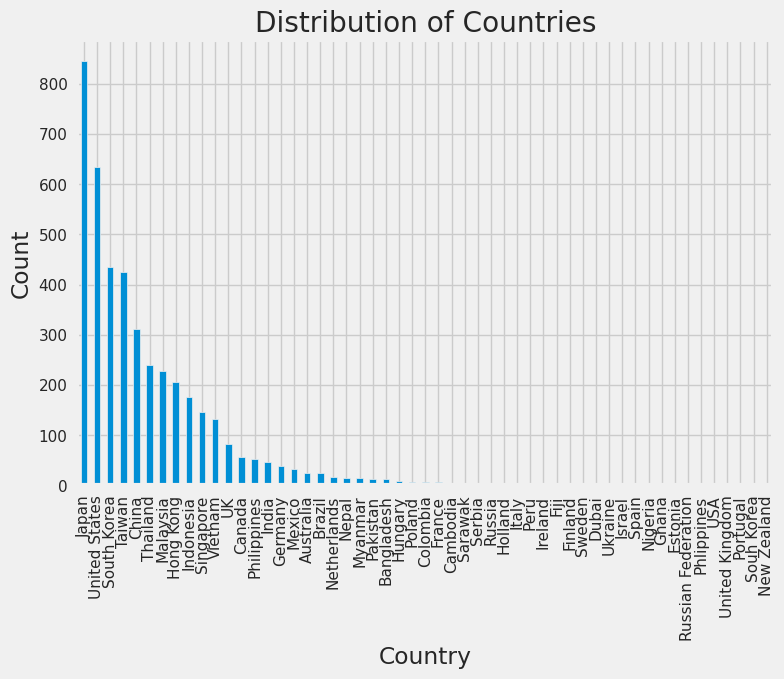

In [10]:
data["Reviewed"]["Country"].value_counts().plot(kind="bar")
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Distribution of Countries")
plt.show()

In [11]:
# Create dictionary to catch rare mistakes
exceptions = {
    "Russia": ["Russia", "Russian Federation"],
    "United States": ["United States", "US", "USA"],
    "UAE": ["Dubai"],
    "Netherlands": ["Holland"],
    "Malaysia": ["Sarawak"],
    "South Korea": ["South Korea", "Souh Korea"],
    "United Kingdom": ["UK"],
    "Philippines": ["Phlippines", "Phlippines"],
    "United Kingdom": ["UK"],
}

In [12]:
# Define a function to correct exceptions in country names
def correct_exception(input_country: str, exceptions: dict = exceptions):
    for key, val in exceptions.items():
        if input_country in val:
            return key
    else:
        return input_country


# Apply the correct_exception function to the "Country" column in each sheet
for sheet in sheet_names:
    data[sheet]["Country"] = data[sheet]["Country"].apply(
        lambda x: correct_exception(x)
    )

In [13]:
# Get the countries with counts less than 20
other_countries = pd.DataFrame(
    {
        "Counts": data["Reviewed"]["Country"].value_counts(),
        "Country": data["Reviewed"]["Country"].value_counts().index,
    }
)
other_countries = other_countries[other_countries["Counts"] < 20]["Country"]

# Update the country values to "Other" for countries with counts less than 20
for sheet in sheet_names:
    data[sheet]["Country"] = data[sheet]["Country"].apply(
        lambda x: "Other" if x in other_countries else x
    )

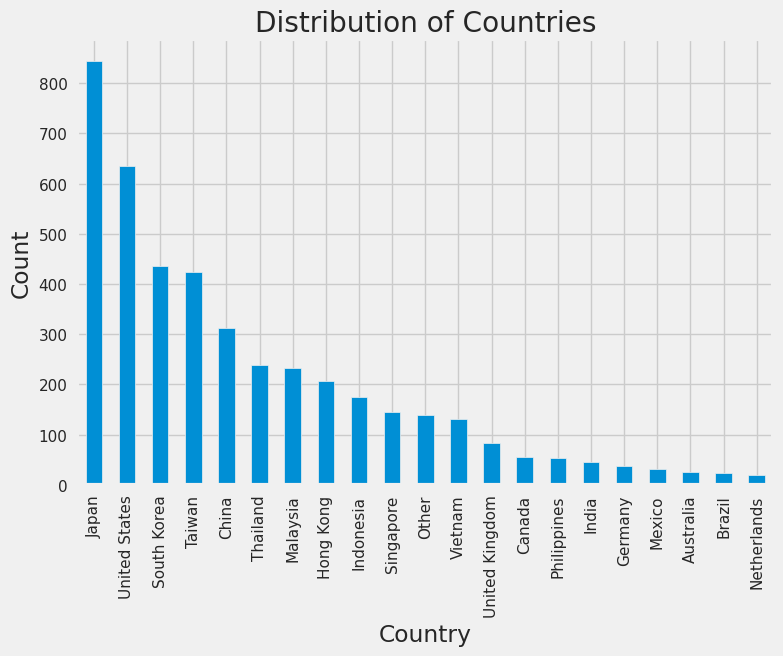

In [14]:
data["Reviewed"]["Country"].value_counts().plot(kind="bar")
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Distribution of Countries")
plt.show()

## Standardize stars to the closest 0.25 incremental rating
- Reassign values like `4.5/5` and `5/4.5` as `4.5`.
- Reassign values like `4-4` and `5-5` as `4` and `5`, respectively.
- Round values that are not divisible by `0.25` to the nearest `0.25` increment.
- Take the average of values like `2.5/3.5`, then round to the nearest `0.25` increment.

In [15]:
# Standardize stars to closest 0.25 incremental rating
stars = []


def standardize_stars(x: str):
    def conditions(x1, x2):
        if x1 == 5 and x2 <= 5:
            return float(x2)
        elif x2 == 5 and x1 <= 5:
            return float(x1)
        elif x1 == x2:
            return float(x1)
        elif x1 != x2:
            x = (x1 + x2) / 2  # average the 2 values
            x = 0.25 * np.round(float(x) / 0.25, 0)  # round to nearest 0.25
            return x
        else:
            return np.nan

    try:
        if float(x) % 0.25 != 0:  # if not divisible by 0.25
            x = 0.25 * np.round(float(x) / 0.25, 0)  # round to nearest 0.25
            return x
        return float(x)
    except ValueError:
        if "/" in x:
            x1, x2 = [float(i) for i in x.split("/")]
            return conditions(x1, x2)
        if "-" in x:
            x1, x2 = [float(i) for i in x.split(" ")[0].split("-")][1:3]
            return conditions(x1, x2)
        else:
            return np.nan


for sheet in sheet_names:
    try:
        stars += list(data[sheet]["Stars"].apply(lambda x: standardize_stars(x)))
    except KeyError:
        pass

In [16]:
# Check to see if there are any star ratings that are not divisible by 0.25 or are not np.nan
for i in list(set(stars)):
    if i % 0.25 != 0 and not np.isnan(i):
        print(i)

In [17]:
# Standardize stars in each sheet
for sheet in sheet_names:
    try:
        # Apply the standardize_stars function to the "Stars" column
        data[sheet]["Stars"] = data[sheet]["Stars"].apply(
            lambda x: standardize_stars(x)
        )
        # Convert the "Stars" column to float
        data[sheet].astype({"Stars": "float"}).dtypes
    except KeyError:
        pass

**Handling missing values**: There are very few rows with missing values in `Stars` and `Style`, so we can drop these rows without affecting key trends.

In [18]:
# Drop the row with a missing `Stars` value in `Review`
data["Reviewed"].dropna(subset=["Stars"], inplace=True)

# Drop the 2 rows with missing `Style` values in `The Ramen Rater - Big List Of A`
data["The Ramen Rater - Big List Of A"].dropna(subset=["Style"], inplace=True)

## Clean up the `Variety` column by converting all to lowercase and removing special characters

In [19]:
# Clean up the `Variety` column by replacing non-alphanumeric characters and converting to lowercase
def replace_non_alphanumeric(string):
    string = re.sub(r"\W+", " ", string)
    return string.lower()


for sheet in sheet_names:
    data[sheet]["Variety"] = data[sheet]["Variety"].apply(
        lambda x: replace_non_alphanumeric(x)
    )

# Group rare `Style` categories into `Other`
Rare categories include `Restaurant`, `Bottle`, `Can`, and `Bar`.


In [20]:
def group_style(x):
    if x in ["Restaurant", "Bottle", "Can", "Bar", "Box"]:
        return "Other"
    else:
        return x


for sheet in sheet_names:
    data[sheet]["Style"] = data[sheet]["Style"].apply(lambda x: group_style(x))

## Exploratory data analysis with `autoviz`

Shape of your Data Set loaded: (4292, 9)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    9 Predictors classified...
        4 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['Review #', 'T', 'T_year', 'T_rank']
To fix data quality issues automatically, import FixDQ from autoviz...


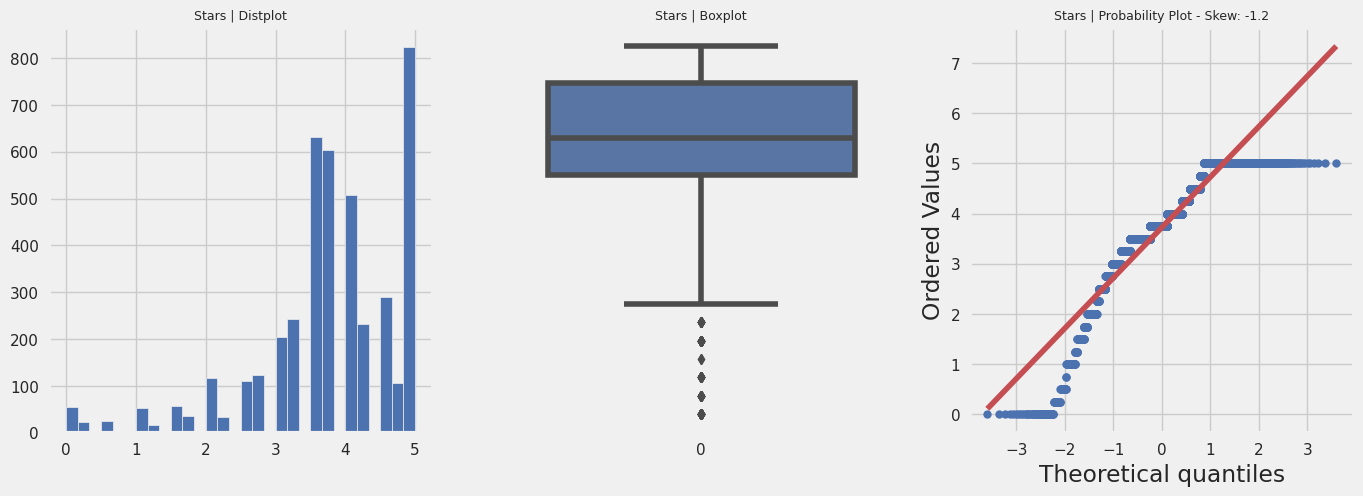

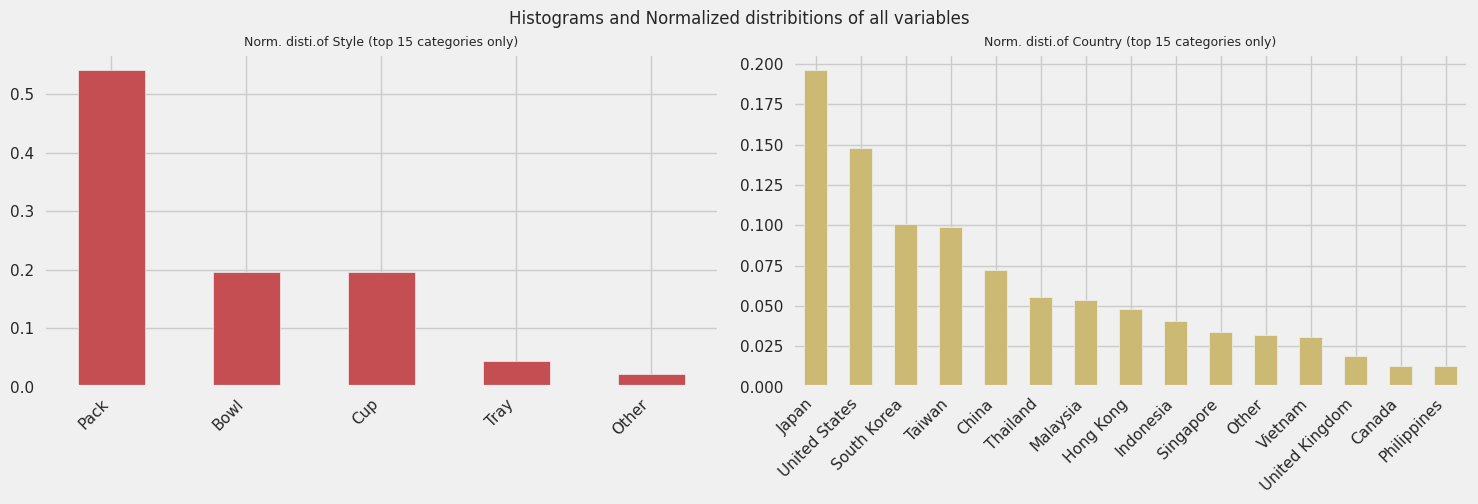

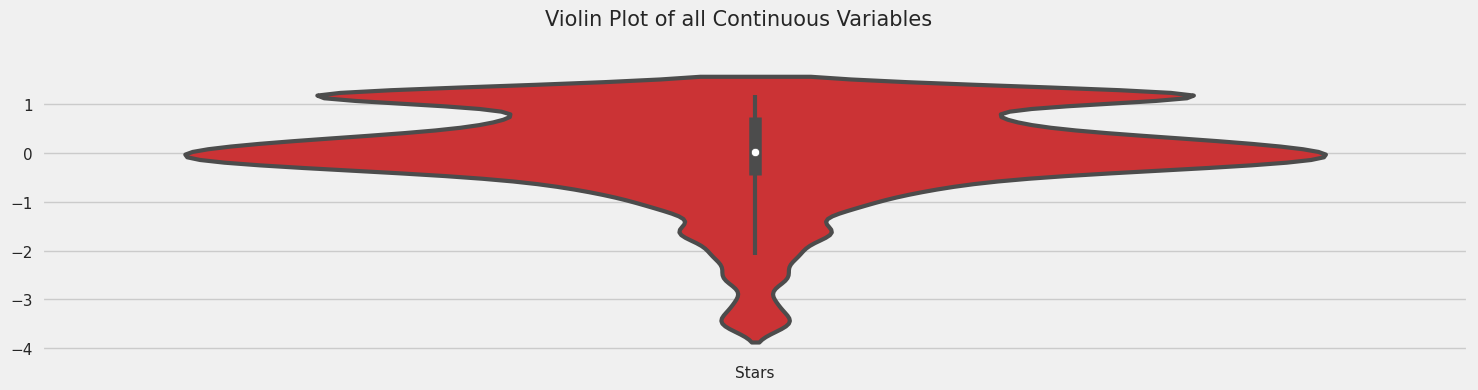

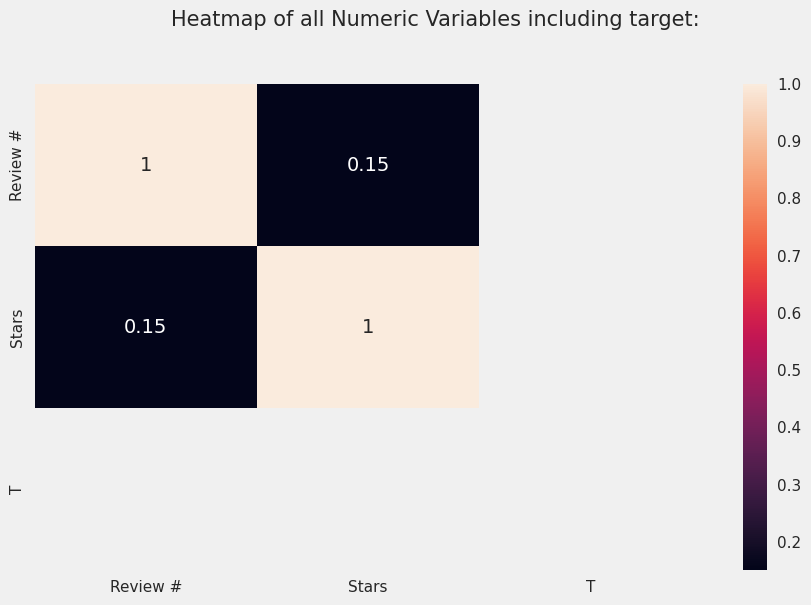

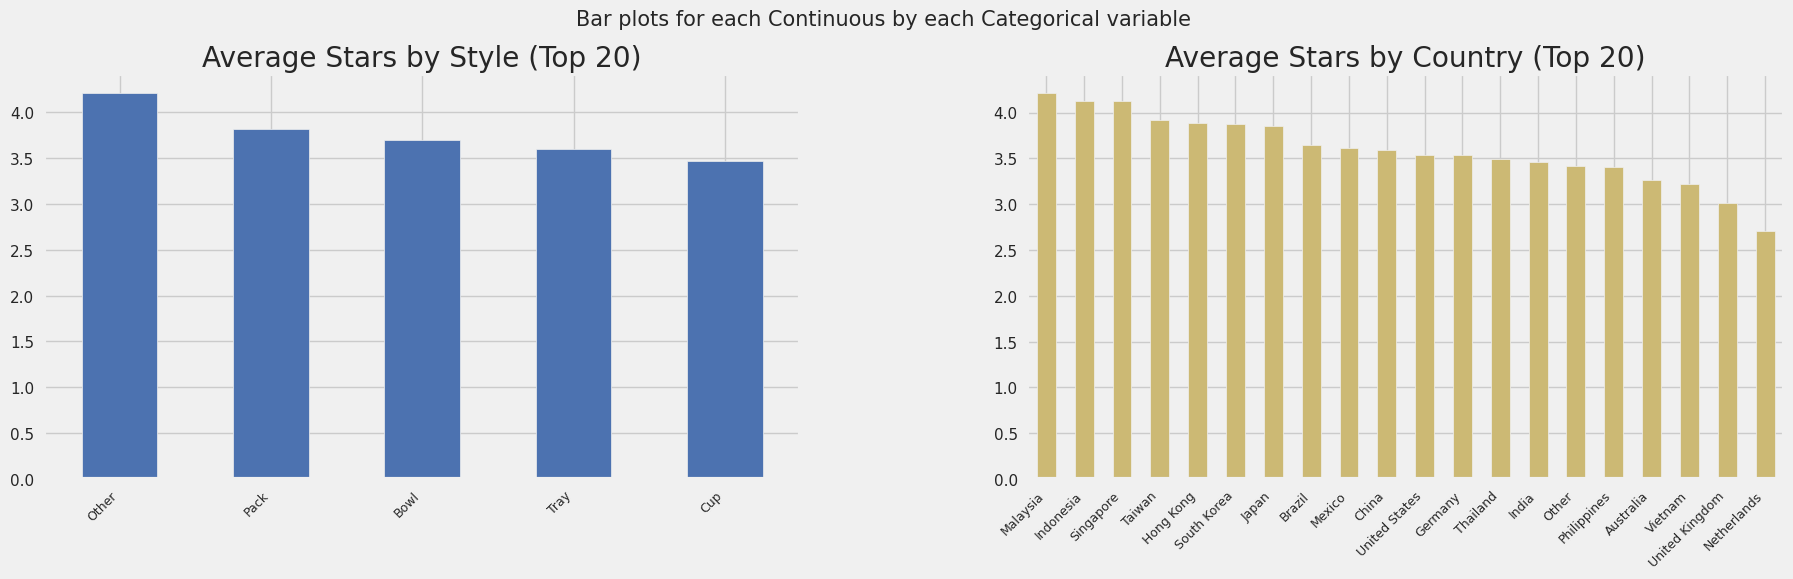

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/alice/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/alice/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/alice/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/alice/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/alice/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/alice/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!

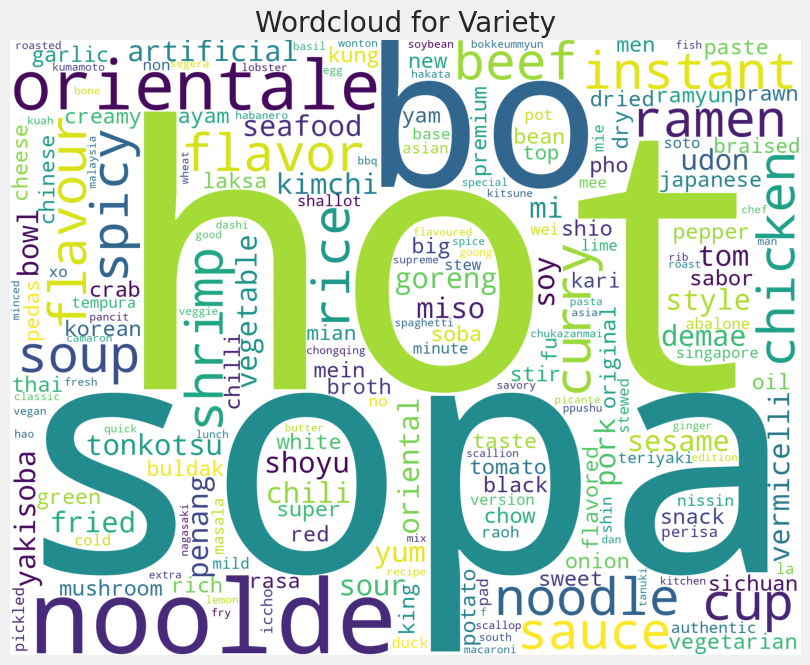

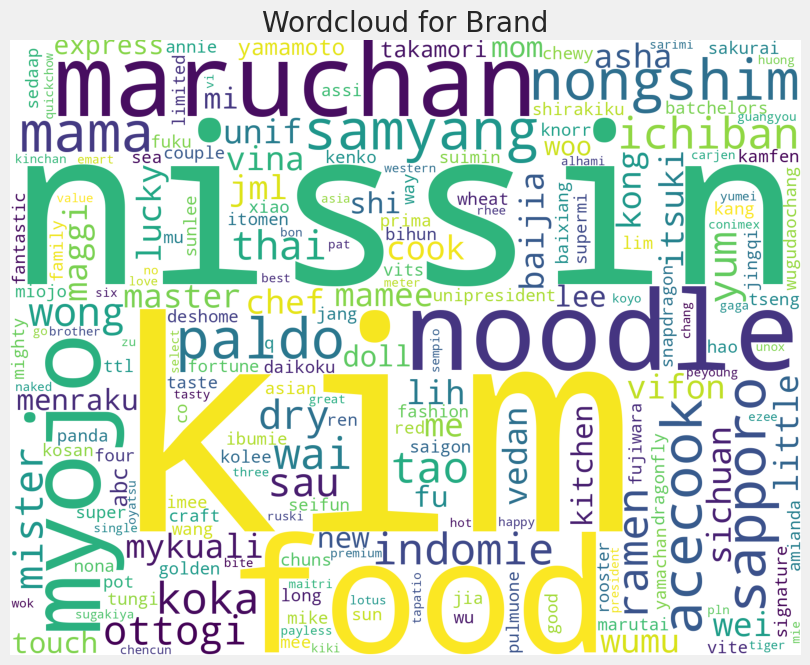

All Plots done
Time to run AutoViz = 16 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [21]:
dft = AV.AutoViz("", dfte=data["Reviewed"])

## Create a new `Flavor` column for common meat flavors based on the word cloud generated from the `Variety` column

In [22]:
# Define a function to extract flavors from the variety column
def extract_flavor(value: str):
    output = []
    common_flavours = {
        "Pork": [
            "tonkotsu",
            "pork",
        ],
        "Beef": ["beef", " bo"],
        "Chicken": ["chicken", "ayam", "buldak"],
        "Seafood": [
            "seafood",
            "shrimp",
            "fish",
            "crab",
            "lobster",
            "abalone",
            "prawn",
            "pancit",
        ],
        "Duck": ["duck"],
    }
    val = value.lower()
    for k, labels in common_flavours.items():
        for v in labels:
            if v in val:
                output.append(k)
    output = list(set(output))
    if len(output) > 1:
        return "Mixed"
    elif len(output) == 1:
        return output[0]


data["Reviewed"]["Flavor"] = [extract_flavor(x) for x in data["Reviewed"]["Variety"]]

## Export `Reviewed` dataset as the working dataset

In [23]:
data["Reviewed"].to_csv("data/reviewed.csv", index=False)